# Sales Forecasting Model Evaluation

The dataset contains weekly sales for six distinct products from a beverage company over the span of a little over three years.

### Table of Contents

- [Overview](#ov)
- [Data Cleaning and Transformation](#dc)
- [Initial Problem](#ip)
- [Random Forest](#rf)
- [Extra Tree Regressor](#etr)
- [XGBoost](#xgb)
- [Decision Trees](#dt)
- [Linear Regression](#lr)
- [Results](#re)

### Overview<a id='ov'></a>


Our objectives are as follows:
- Clean and transform the data
- Create and remove features
- Perform forecasting with models
- Select the best performing model

### Data Cleaning and Transforming<a id='dc'></a>

We'll begin by loading in some libraries and the data we'll be working with:

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
df = pd.read_csv('sales_forecast.csv')
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1218 non-null   object 
 1   date                1218 non-null   object 
 2   Sales               1218 non-null   int64  
 3   Price Discount (%)  1218 non-null   object 
 4   In-Store Promo      1218 non-null   int64  
 5   Catalogue Promo     1218 non-null   int64  
 6   Store End Promo     1218 non-null   int64  
 7   Google_Mobility     1218 non-null   float64
 8   Covid_Flag          1218 non-null   int64  
 9   V_DAY               1218 non-null   int64  
 10  EASTER              1218 non-null   int64  
 11  CHRISTMAS           1218 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 114.3+ KB


In [109]:
df.isna().sum()

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

* There is no null value present in the dataset

In [110]:
# removing the percentage sign and then formatting as float

df['Price Discount (%)'] = df['Price Discount (%)'].replace('%','', regex = True).astype(np.float64)
df['Price Discount (%)']

0        0.0
1        0.0
2       17.0
3        0.0
4       17.0
        ... 
1213    54.0
1214    52.0
1215    54.0
1216    44.0
1217    44.0
Name: Price Discount (%), Length: 1218, dtype: float64

In [111]:
df['Product'].nunique()

6

We can do some visual inspections of the sales distributions within our dataframe to spot any outliers.

<Axes: >

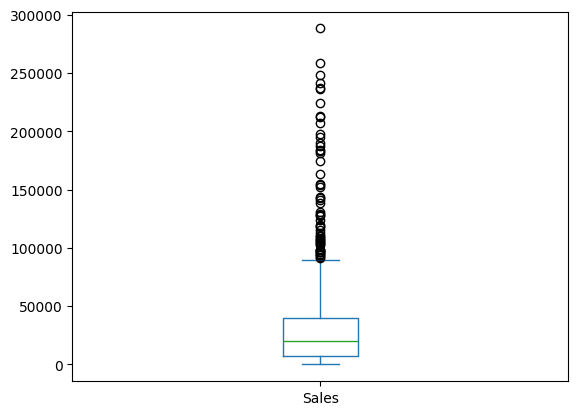

In [112]:
df['Sales'].plot(kind = 'box')

Data points above the maximum of a boxplot isn't a good sign, especially when we're building a model with such limited data. We should gauge the skew of the Sales distribution.

<Axes: ylabel='Frequency'>

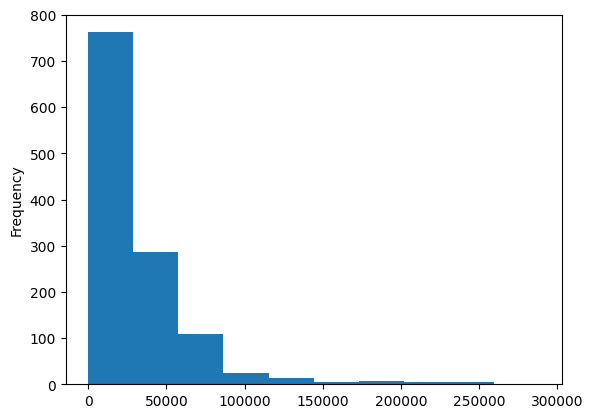

In [113]:
df['Sales'].plot(kind = 'hist')

We can see that the distribution is incredibly skewed, with very few data points above 100,000 sales. Not only will this alter our averages and summaries, but it can only do harm to our model. We'll have to remove the datapoints above 100,000 and examine the new distribution.

<Axes: ylabel='Frequency'>

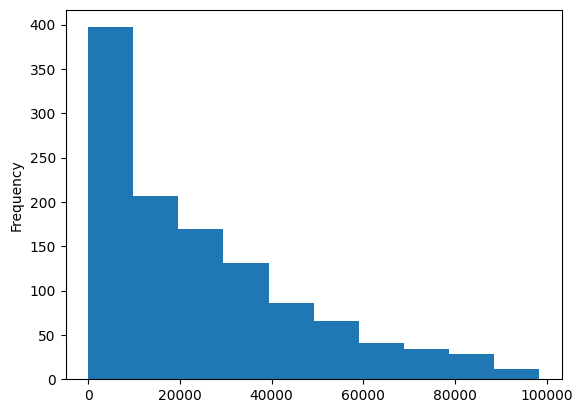

In [114]:
df = df[df['Sales'] <= 100000]

df['Sales'].plot(kind = 'hist')

<Axes: >

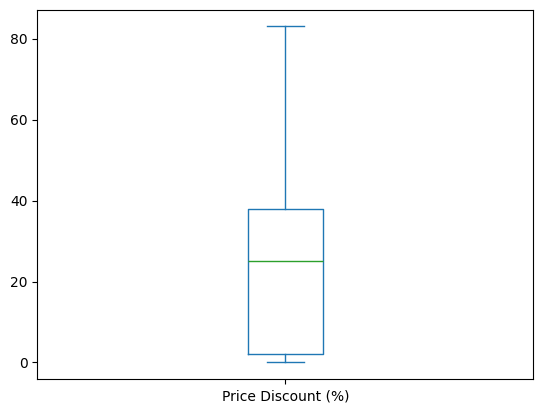

In [115]:
df['Price Discount (%)'].plot(kind = 'box')

The Price Discount column's distribution appears normal.

In [116]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1172 non-null   object 
 1   date                1172 non-null   object 
 2   Sales               1172 non-null   int64  
 3   Price Discount (%)  1172 non-null   float64
 4   In-Store Promo      1172 non-null   int64  
 5   Catalogue Promo     1172 non-null   int64  
 6   Store End Promo     1172 non-null   int64  
 7   Google_Mobility     1172 non-null   float64
 8   Covid_Flag          1172 non-null   int64  
 9   V_DAY               1172 non-null   int64  
 10  EASTER              1172 non-null   int64  
 11  CHRISTMAS           1172 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 119.0+ KB


In [117]:
df = df.drop_duplicates(subset = ['Product','Sales','Price Discount (%)','date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1172 non-null   object 
 1   date                1172 non-null   object 
 2   Sales               1172 non-null   int64  
 3   Price Discount (%)  1172 non-null   float64
 4   In-Store Promo      1172 non-null   int64  
 5   Catalogue Promo     1172 non-null   int64  
 6   Store End Promo     1172 non-null   int64  
 7   Google_Mobility     1172 non-null   float64
 8   Covid_Flag          1172 non-null   int64  
 9   V_DAY               1172 non-null   int64  
 10  EASTER              1172 non-null   int64  
 11  CHRISTMAS           1172 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 119.0+ KB


Next we will convert the date column to the datetime format

In [118]:
df['date'] = pd.to_datetime(df.date, format = '%m/%d/%Y')
df['date']

0      2017-02-05
1      2017-02-12
2      2017-02-19
3      2017-02-26
4      2017-03-05
          ...    
1211   2020-10-04
1212   2020-10-11
1213   2020-10-18
1216   2020-11-08
1217   2020-11-15
Name: date, Length: 1172, dtype: datetime64[ns]

Now we can check when the data's timeframe begins and ends.

In [119]:
print('The actual dataframe starts at',df.date.min(),'.')
print('The actual dataframe ends at',df.date.max(),'.')

The actual dataframe starts at 2017-02-05 00:00:00 .
The actual dataframe ends at 2020-12-27 00:00:00 .


In [120]:
actual_duration = pd.date_range(start='2017-02-05', end = '2020-12-27', freq = 'W')
len(actual_duration)

204

In [121]:
df.date.nunique()

204

The Sales data is in a weekly format.

In [122]:
df = df.set_index('date')
df

,Product,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,,
2017-02-05,SKU1,27750,0.0,0,0,0,0.00,0,0,0,0
2017-02-12,SKU1,29023,0.0,1,0,1,0.00,0,1,0,0
2017-02-19,SKU1,45630,17.0,0,0,0,0.00,0,0,0,0
2017-02-26,SKU1,26789,0.0,1,0,1,0.00,0,0,0,0
2017-03-05,SKU1,41999,17.0,0,0,0,0.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,SKU6,23072,44.0,1,0,1,-9.73,1,0,0,0
2020-10-11,SKU6,42044,44.0,0,1,0,-7.39,1,0,0,0
2020-10-18,SKU6,96619,54.0,0,1,0,-7.56,1,0,0,0


In [123]:
df.index.nunique()

204

Knowing that all the dates are accounted for, we can now begin feature creation from the date column:

In [124]:
def create_features(df):
    
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['date'] = df.index.date # note that this will be in YYYY-mm-dd format
    return df

dfe = create_features(df)
dfe

,Product,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,quarter,month,year,dayofyear,date
date,,,,,,,,,,,,,,,,
2017-02-05,SKU1,27750,0.0,0,0,0,0.00,0,0,0,0,1,2,2017,36,2017-02-05
2017-02-12,SKU1,29023,0.0,1,0,1,0.00,0,1,0,0,1,2,2017,43,2017-02-12
2017-02-19,SKU1,45630,17.0,0,0,0,0.00,0,0,0,0,1,2,2017,50,2017-02-19
2017-02-26,SKU1,26789,0.0,1,0,1,0.00,0,0,0,0,1,2,2017,57,2017-02-26
2017-03-05,SKU1,41999,17.0,0,0,0,0.00,0,0,0,0,1,3,2017,64,2017-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,SKU6,23072,44.0,1,0,1,-9.73,1,0,0,0,4,10,2020,278,2020-10-04
2020-10-11,SKU6,42044,44.0,0,1,0,-7.39,1,0,0,0,4,10,2020,285,2020-10-11
2020-10-18,SKU6,96619,54.0,0,1,0,-7.56,1,0,0,0,4,10,2020,292,2020-10-18


In [125]:
# seeing what we're working with

dfe.Product.unique()

array(['SKU1', 'SKU2', 'SKU3', 'SKU4', 'SKU5', 'SKU6'], dtype=object)

In [126]:
dfe.groupby('Product')['date'].nunique()

Product
SKU1    195
SKU2    204
SKU3    189
SKU4    204
SKU5    204
SKU6    176
Name: date, dtype: int64

We'll change the Product codes to integers

In [127]:
dfe['Product'] = dfe['Product'].str.replace('SKU','').astype(int)
dfe['Product']

date
2017-02-05    1
2017-02-12    1
2017-02-19    1
2017-02-26    1
2017-03-05    1
             ..
2020-10-04    6
2020-10-11    6
2020-10-18    6
2020-11-08    6
2020-11-15    6
Name: Product, Length: 1172, dtype: int64

In [128]:

correlation_stat = dfe.drop(['date'], axis = 1)

print(correlation_stat.corr())

                     Product     Sales  Price Discount (%)  In-Store Promo  \
Product             1.000000 -0.190224            0.272661        0.006526   
Sales              -0.190224  1.000000            0.378029        0.238575   
Price Discount (%)  0.272661  0.378029            1.000000        0.198749   
In-Store Promo      0.006526  0.238575            0.198749        1.000000   
Catalogue Promo     0.122652 -0.155845           -0.069161       -0.483776   
Store End Promo     0.084565  0.202593            0.192391        0.358685   
Google_Mobility     0.002014  0.037620           -0.228361        0.052228   
Covid_Flag         -0.010555 -0.082815            0.299863       -0.021963   
V_DAY               0.004687 -0.025064           -0.047809        0.017311   
EASTER              0.002926  0.016532            0.007866        0.023471   
CHRISTMAS          -0.006255 -0.025400           -0.005835        0.017311   
quarter            -0.013939  0.024798            0.039523      

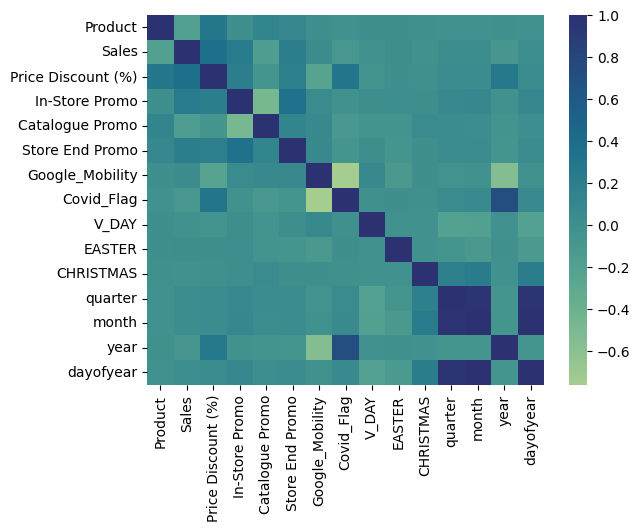

In [129]:
dataplot = sns.heatmap(correlation_stat.corr(), cmap = 'crest')
plt.show()

We can see that most columns are fairly mild in terms of correlation. We will remove the V_DAY, EASTER, and CHRISTMAS boolean columns as they are only true for very few weeks in our timeframe, and since the newly created dayofyear column will take their place.

In [130]:
# removing columns

dfe = dfe.drop(['V_DAY','EASTER','CHRISTMAS'], axis = 1)

In [131]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1172 entries, 2017-02-05 to 2020-11-15
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1172 non-null   int64  
 1   Sales               1172 non-null   int64  
 2   Price Discount (%)  1172 non-null   float64
 3   In-Store Promo      1172 non-null   int64  
 4   Catalogue Promo     1172 non-null   int64  
 5   Store End Promo     1172 non-null   int64  
 6   Google_Mobility     1172 non-null   float64
 7   Covid_Flag          1172 non-null   int64  
 8   quarter             1172 non-null   int32  
 9   month               1172 non-null   int32  
 10  year                1172 non-null   int32  
 11  dayofyear           1172 non-null   int32  
 12  date                1172 non-null   object 
dtypes: float64(2), int32(4), int64(6), object(1)
memory usage: 142.2+ KB


In [132]:
# checking values for products after modifying to ints

dfe.Product.unique()

array([1, 2, 3, 4, 5, 6])

### Initial Problem<a id='ip'></a>

As of now, we will consider only one product for forecasting purpose

In [133]:
# removing all other entries except for SKU1

dfe = dfe[dfe['Product'] == 1]
dfe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2017-02-05 to 2020-12-27
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             195 non-null    int64  
 1   Sales               195 non-null    int64  
 2   Price Discount (%)  195 non-null    float64
 3   In-Store Promo      195 non-null    int64  
 4   Catalogue Promo     195 non-null    int64  
 5   Store End Promo     195 non-null    int64  
 6   Google_Mobility     195 non-null    float64
 7   Covid_Flag          195 non-null    int64  
 8   quarter             195 non-null    int32  
 9   month               195 non-null    int32  
 10  year                195 non-null    int32  
 11  dayofyear           195 non-null    int32  
 12  date                195 non-null    object 
dtypes: float64(2), int32(4), int64(6), object(1)
memory usage: 18.3+ KB


We will evaluate year 2020's Q3 and Q4, but as several of the Product codes (including SKU1) abruptly end their sales data on __November 15th, 2020__, so we'll cut the forecast to that date.

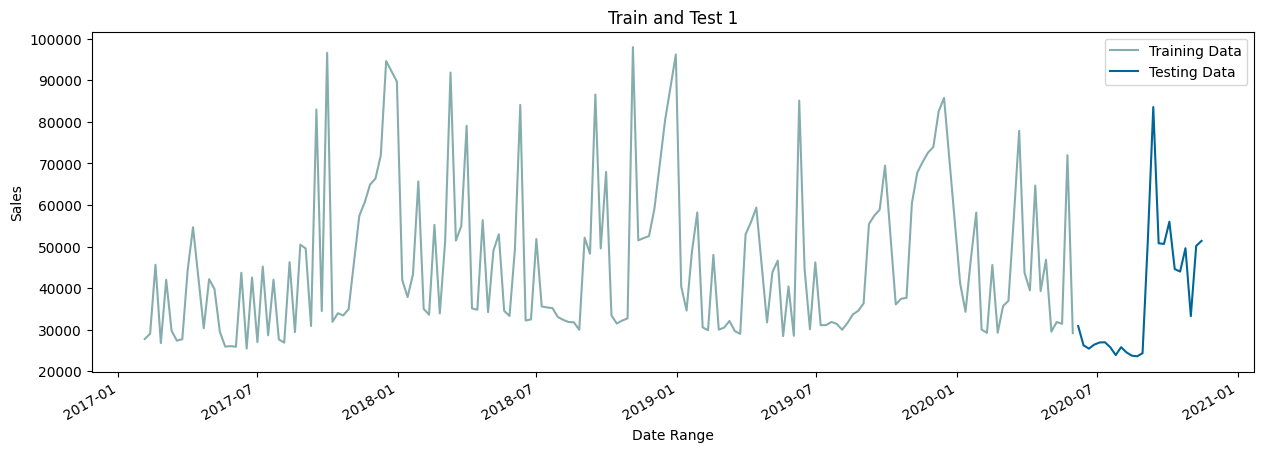

In [134]:
train_data = dfe.loc[(dfe.index >= '02-05-2017') & (dfe.index <= '05-31-2020')] # training
test_data = dfe.loc[(dfe.index >= '06-01-2020') & (dfe.index <='11-15-2020')] # quarter 3-4

# plotting

plt.subplots(1,1, figsize= (15,5))
train_data['Sales'].plot(color='#85adad')
test_data['Sales'].plot(color='#006699')
plt.ylabel('Sales')
plt.xlabel('Date Range')
location = 0
legend_drawn_flag = True
plt.title('Train and Test 1')
plt.legend(['Training Data','Testing Data'], loc=0, frameon = legend_drawn_flag)
plt.show();

In [135]:
dfe.columns

Index(['Product', 'Sales', 'Price Discount (%)', 'In-Store Promo',
       'Catalogue Promo', 'Store End Promo', 'Google_Mobility', 'Covid_Flag',
       'quarter', 'month', 'year', 'dayofyear', 'date'],
      dtype='object')

In [136]:
# columns we will train on

FEATURES = ['Product',
            'Price Discount (%)',
            'In-Store Promo', 
            'Catalogue Promo',
            'Store End Promo', 
            'Google_Mobility',
            'Covid_Flag', 
            'quarter',
            'month',
            'year',
            'dayofyear']

# column we are trying to predict

TARGET = ['Sales']

In [137]:
# training on training data

X_train_one = train_data[FEATURES]
y_train_one = train_data[TARGET]

# testing on testing data

X_test_one = test_data[FEATURES]
y_test_one = test_data[TARGET]

### Random Forest Regression<a id='rf'></a>

In [188]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

random_forest = RandomForestRegressor(random_state = 42, n_estimators=100)
random_forest.fit(X_train_one, y_train_one)

Y_pred_forest = random_forest.predict(X_test_one)

In [189]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

# variable creation

forest_mape = round((mean_absolute_percentage_error(Y_pred_forest, y_test_one) * 100),3)
forest_mae = mean_absolute_error(Y_pred_forest, y_test_one)
forest_r2 = r2_score(y_test_one, Y_pred_forest)

# printing results

print('Mean Absolute Percentage Error:',forest_mape,'%.')
print('Mean Absolute Error:',forest_mae,'.')
print('R-Squared:',forest_r2,'.')

Mean Absolute Percentage Error: 17.468 %.
Mean Absolute Error: 7712.80125 .
R-Squared: 0.6271168633054991 .


### Extra Tree Regressor<a id='etr'></a>

In [216]:
extratree_reg = ExtraTreesRegressor(random_state = 0, n_estimators=1000)
extratree_reg.fit(X_train_one, y_train_one)

Y_pred_extratree = extratree_reg.predict(X_test_one)

In [217]:
# variable creation

extratree_mape = round((mean_absolute_percentage_error(Y_pred_forest, y_test_one) * 100),3)
extratree_mae = mean_absolute_error(Y_pred_forest, y_test_one)
extratree_r2 = r2_score(y_test_one, Y_pred_forest)

# printing results

print('Mean Absolute Percentage Error:',extratree_mape,'%.')
print('Mean Absolute Error:',extratree_mae,'.')
print('R-Squared:',extratree_r2,'.')

Mean Absolute Percentage Error: 14.953 %.
Mean Absolute Error: 6372.840125 .
R-Squared: 0.7524867772615889 .


In [218]:
# feature importances, according to extra tree model

fi = pd.DataFrame(data = extratree_reg.feature_importances_,
                 index = extratree_reg.feature_names_in_,
                 columns = ['importance'])

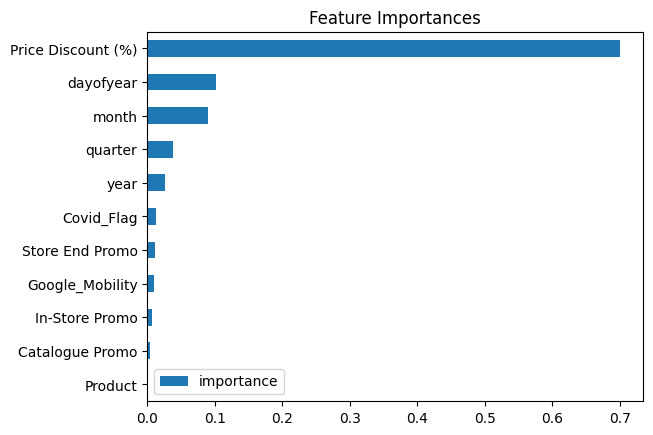

In [219]:
fi.sort_values('importance').plot(kind = 'barh',
                                 title = 'Feature Importances')
plt.show()

Here we can see that a Product having a discount is a large factor in sales demand, with dayofyear following behind.

In [220]:
test_data['prediction'] = extratree_reg.predict(X_test_one)

In [221]:
# adding the predictions to our df

dfe3 = dfe.merge(test_data[['prediction']],
                 how = 'left',
                 left_index = True,
                 right_index = True)

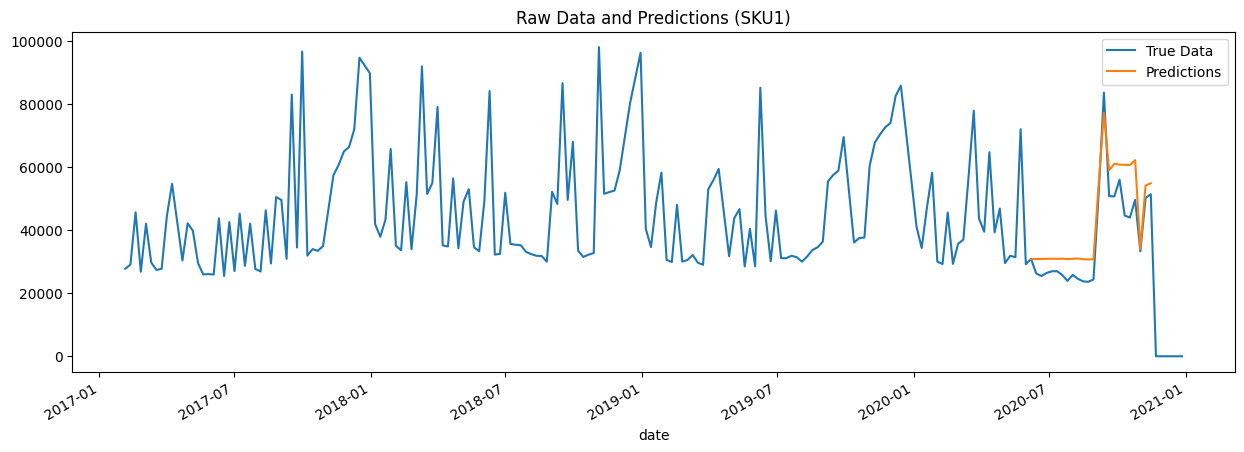

In [222]:
# plotting our predictions compared to the provided dataset values 

ax = dfe3[['Sales']].plot(figsize = (15,5))

dfe3['prediction'].plot(ax = ax)
plt.legend(['True Data','Predictions'])
ax.set_title('Raw Data and Predictions (SKU1)')
plt.show()

### XGBoost Regression<a id='xgb'></a>

In [213]:
import xgboost as xgb

reg = xgb.XGBRegressor(random_state = 0,
                       n_estimators = 1800,
                       max_depth = 3,
                       early_stopping_rounds = 50,
                       learning_rate = 0.001)


reg.fit(X_train_one, y_train_one,
       eval_set = [(X_train_one, y_train_one), (X_test_one, y_test_one)],
       verbose = 100)

[0]	validation_0-rmse:17904.80344	validation_1-rmse:17139.53324


[100]	validation_0-rmse:16543.71015	validation_1-rmse:15929.62999
[200]	validation_0-rmse:15324.37836	validation_1-rmse:14898.31399
[300]	validation_0-rmse:14229.09930	validation_1-rmse:14015.59555
[400]	validation_0-rmse:13242.88818	validation_1-rmse:13270.69806
[500]	validation_0-rmse:12355.27265	validation_1-rmse:12651.06277
[600]	validation_0-rmse:11560.59737	validation_1-rmse:12201.86591
[700]	validation_0-rmse:10851.24886	validation_1-rmse:11829.47271
[800]	validation_0-rmse:10215.99082	validation_1-rmse:11525.71212
[900]	validation_0-rmse:9647.45517	validation_1-rmse:11283.24319
[1000]	validation_0-rmse:9138.80253	validation_1-rmse:11019.34340
[1100]	validation_0-rmse:8682.05942	validation_1-rmse:10800.80220
[1200]	validation_0-rmse:8272.71701	validation_1-rmse:10621.20700
[1300]	validation_0-rmse:7906.29441	validation_1-rmse:10474.73907
[1400]	validation_0-rmse:7579.04991	validation_1-rmse:10345.42480
[1500]	validation_0-rmse:7288.01261	validation_1-rmse:10227.83618
[1600]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1800, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [212]:
# xgb


xgb_mape = round((mean_absolute_percentage_error(test_data['Sales'], test_data['prediction']) *100),3)
xgb_mae = mean_absolute_error(test_data['prediction'], test_data['Sales'])
xgb_r2 = r2_score(test_data['Sales'],test_data['prediction'])


print('Mean Absolute Percentage Error:',xgb_mape,'%.')
print('Mean Absolute Error:',xgb_mae,'.')
print('R-Squared:',xgb_r2,'.')

Mean Absolute Percentage Error: 30.059 %.
Mean Absolute Error: 9105.0654296875 .
R-Squared: 0.5594291687011719 .


### Decision Tree Regressor<a id='dt'></a>

In [151]:
from sklearn.tree import DecisionTreeRegressor

regressor_tree = DecisionTreeRegressor(random_state = 0)

regressor_tree.fit(X_train_one, y_train_one)

DecisionTreeRegressor(random_state=0)

In [152]:
regressor_tree.predict(X_test_one)

array([29177., 30099., 30099., 30099., 31093., 31099., 31866., 31386.,
       29985., 31628., 29536., 29536., 29536., 55431., 71971., 58872.,
       67966., 67966., 67966., 60365., 60365., 37663., 51495., 52532.])

In [153]:
# decision trees

# variable creation

decision_mape = round((mean_absolute_percentage_error(test_data['Sales'], regressor_tree.predict(X_test_one))* 100),3)
decision_mae = mean_absolute_error(regressor_tree.predict(X_test_one), test_data['Sales'])
decision_r2 = r2_score(test_data['Sales'],regressor_tree.predict(X_test_one))

# printing results

print('Mean Absolute Percentage Error:',decision_mape,'%.')
print('Mean Absolute Error:',decision_mae,'.')
print('R-Squared:',decision_r2,'.')

Mean Absolute Percentage Error: 19.834 %.
Mean Absolute Error: 7246.166666666667 .
R-Squared: 0.6431473023327279 .


### Linear Regression<a id='lr'></a>

In [154]:
from sklearn import linear_model

regr_linear = linear_model.LinearRegression()
regr_linear.fit(X_train_one, y_train_one)

linear_results = regr_linear.predict(X_test_one)
linear_results

array([[39018.94426413],
       [39508.27445382],
       [40131.55089393],
       [40658.8658412 ],
       [38188.35642261],
       [38954.57550308],
       [39529.87119677],
       [40280.09669509],
       [40146.73187877],
       [40938.94053021],
       [42284.92696319],
       [42825.23669595],
       [46609.15493718],
       [65550.42773551],
       [98150.80246138],
       [67380.07737184],
       [66588.59078462],
       [64258.02520975],
       [64658.3910988 ],
       [65309.65630764],
       [62819.27209415],
       [41219.5424349 ],
       [61191.34658378],
       [61950.56847206]])

In [155]:
# linear regression

# storing as variables

linear_mape = round((mean_absolute_percentage_error(test_data['Sales'], linear_results)* 100),3)
linear_mae = mean_absolute_error(linear_results, test_data['Sales'])
linear_r2 = r2_score(test_data['Sales'], linear_results)

# printing for immediate eval

print('Mean Absolute Percentage Error:',linear_mape,'%.')
print('Mean Absolute Error:',linear_mae,'.')
print('R-Squared:',linear_r2,'.')

Mean Absolute Percentage Error: 44.986 %.
Mean Absolute Error: 14489.217784598566 .
R-Squared: 0.013831340805822379 .


### Results<a id='re'></a>

Finally, we'll combine the results stored in variables into a single dataframe to be visualized.

In [223]:
data = {'model': ['random_forest','extratree', 'xgboost','decision_trees','linear_regression'],
        'mape': [forest_mape,extratree_mape, xgb_mape,decision_mape,linear_mape],
        'mae': [forest_mae,extratree_mae, xgb_mae,decision_mae,linear_mae],
        'r_squared': [forest_r2, extratree_r2, xgb_r2,decision_r2,linear_r2]}

results = pd.DataFrame(data)

results

,model,mape,mae,r_squared
0,random_forest,17.468,7712.801250,0.627117
1,extratree,14.953,6372.840125,0.752487
2,xgboost,30.059,9105.065430,0.559429
3,decision_trees,19.834,7246.166667,0.643147
4,linear_regression,44.986,14489.217785,0.013831


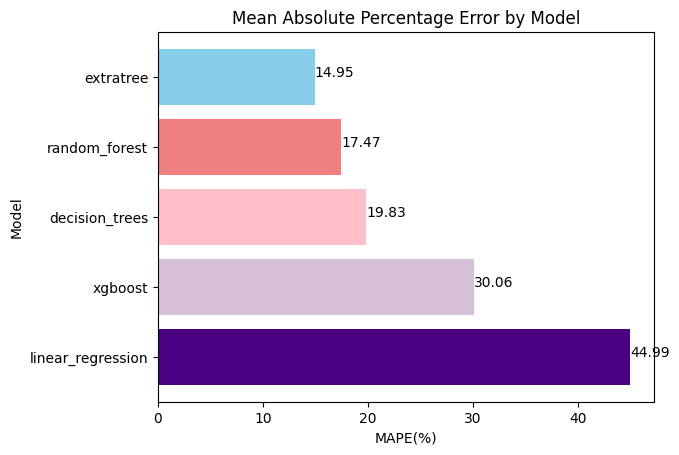

In [224]:
results = results.sort_values(by = 'mape', ascending = False)

y1 = results.model
x1 = round((results.mape),2)

plt.barh(y1,x1, color = ['indigo', 'thistle','pink','lightcoral', 'skyblue'])
plt.title('Mean Absolute Percentage Error by Model')
plt.ylabel('Model')
plt.xlabel('MAPE(%)')

for index, value in enumerate(x1):
    plt.text(value, index,
             str(value))

plt.show()

ExtratreeRegressor has the smallest Mean Absolute Percentage Error.

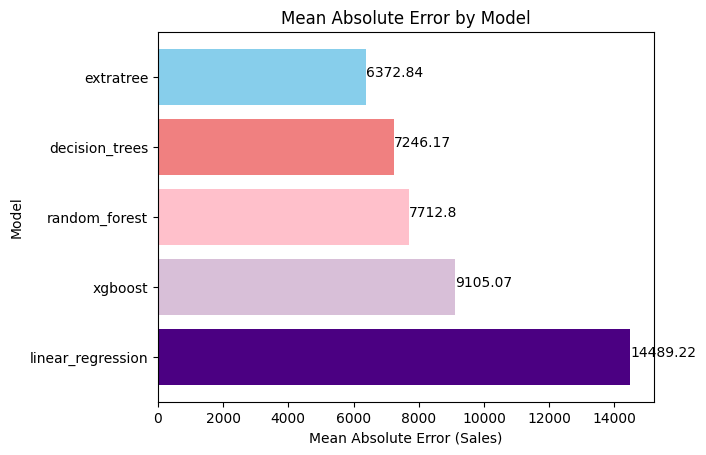

In [229]:
results = results.sort_values(by = 'mae', ascending = False)

y1 = results.model
x1 = round((results.mae),2)

plt.barh(y1,x1, color = ['indigo', 'thistle','pink','lightcoral', 'skyblue'])
plt.title('Mean Absolute Error by Model')
plt.ylabel('Model')
plt.xlabel('Mean Absolute Error (Sales)')

for index, value in enumerate(x1):
    plt.text(value, index,
             str(value))

plt.show()

Similarly, ExtratreeRegressor has the smallest Mean Absolute Error of the four models tested.

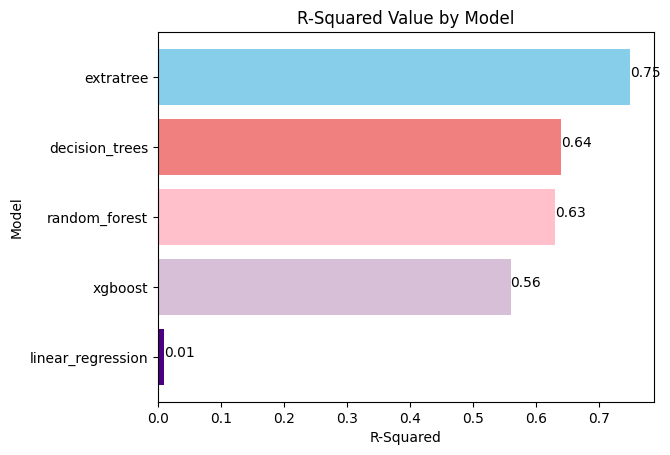

In [230]:
results = results.sort_values(by = 'r_squared', ascending = True)

y1 = results.model
x1 = round((results.r_squared),2)

plt.barh(y1,x1, color = ['indigo', 'thistle','pink','lightcoral', 'skyblue'])
plt.title('R-Squared Value by Model')
plt.ylabel('Model')
plt.xlabel('R-Squared')

for index, value in enumerate(x1):
    plt.text(value, index,
             str(value))

plt.show()

Lastly, ExtratreeRegressor has the highest R-Squared value of the four models tested on a single product.

__Given that ExtratreeRegressor has produced the closest predictions, we select ExtratreeRegressor model for forecasting sales.__